<a href="https://colab.research.google.com/github/pythagoras58/Quantizer/blob/main/SMPC_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
!pip install -U qiskit
!pip install qiskit-aer
!pip install pylatexenc

In [71]:
# Modify all count results
def print_final_result(result):
    print("Final Result (Formatted):\n")
    for binary_key, value in result.items():
        print(f"Binary sequence: {binary_key}, Frequency: {value}")

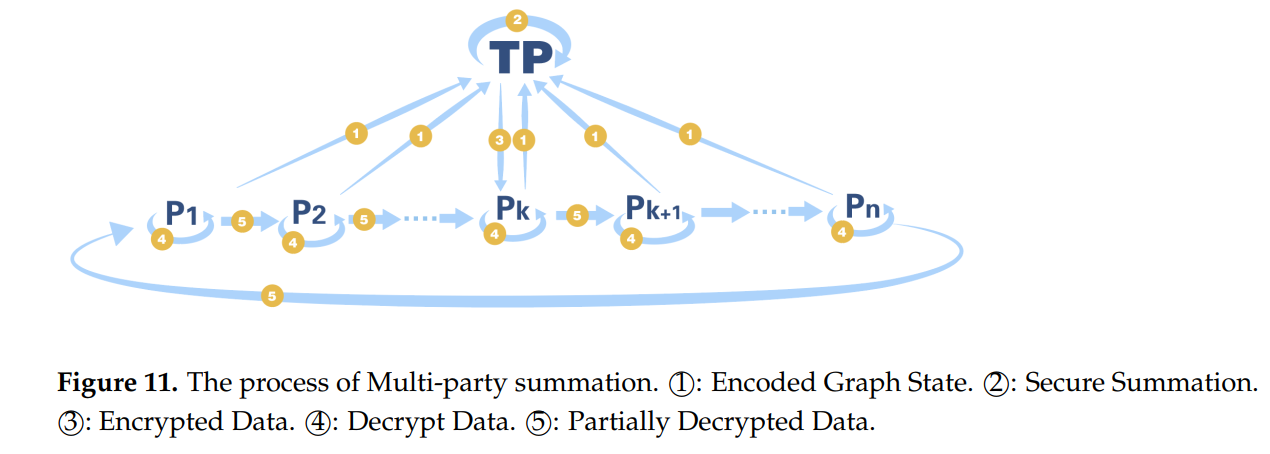

# Graph State Preparation
graph states can be created using a combination of Hadamard gates and Controlled-Z (CZ) gates. The participants in the protocol generate random keys Y_k and use these to determine how to prepare their qubits.

In [72]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, assemble
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

%matplotlib inline

# Create a quantum register for each participant
num_participants = 4  # Assume: 4 participants
qr = QuantumRegister(num_participants)

# Create a quantum circuit
qc = QuantumCircuit(qr)

# Apply Hadamard gate to each qubit to create superposition
for i in range(num_participants):
    qc.h(qr[i])

# Apply Controlled-Z (CZ) gates between qubits to entangle them
for i in range(num_participants - 1):
    qc.cz(qr[i], qr[i+1])

# The quantum circuit now represents a graph state
qc.draw()  # Draw the circuit
#circuit_drawer(qc)

┌───┐         
q17_0: ┤ H ├─■───────
       ├───┤ │       
q17_1: ┤ H ├─■──■────
       ├───┤    │    
q17_2: ┤ H ├────■──■─
       ├───┤       │ 
q17_3: ┤ H ├───────■─
       └───┘

# Data Encoding

Participants use their private keys X_k and Zk
  to encrypt the data by applying gates (X or Z) based on their random values. In Qiskit, X-gates and Z-gates are straightforward.

In [73]:
# Example: Random keys for each participant
import random
X_k = [random.choice([0, 1]) for _ in range(num_participants)]
Z_k = [random.choice([0, 1]) for _ in range(num_participants)]

# Apply X and Z gates according to the random keys
for i in range(num_participants):
    if X_k[i] == 1:
        qc.x(qr[i])
    if Z_k[i] == 1:
        qc.z(qr[i])


# Graph State Verification

After encoding, the Trusted Third Party (TP) measures stabilizers to verify the integrity of the graph state. In Qiskit, stabilizers can be measured by converting them to Pauli measurements (X, Y, or Z).

In [74]:
# Measure stabilizers (X, Y, or Z basis)
qc.measure_all()

# Execute the circuit using Qiskit simulator
from qiskit_aer import AerSimulator
simulator = AerSimulator()
transpiled_qc = transpile(qc, simulator)
#result = execute(transpiled_qc, simulator, shots=1024).result()
result = simulator.run(transpiled_qc, shots=1024).result()
counts = result.get_counts()
print(counts)


{'1000': 78, '0110': 71, '0010': 57, '1011': 68, '0111': 65, '0011': 58, '1111': 52, '0001': 59, '1110': 63, '0100': 77, '0000': 60, '0101': 82, '1001': 54, '1100': 68, '1101': 72, '1010': 40}


In [75]:
print_final_result(counts)

Final Result (Formatted):

Binary sequence: 1000, Frequency: 78
Binary sequence: 0110, Frequency: 71
Binary sequence: 0010, Frequency: 57
Binary sequence: 1011, Frequency: 68
Binary sequence: 0111, Frequency: 65
Binary sequence: 0011, Frequency: 58
Binary sequence: 1111, Frequency: 52
Binary sequence: 0001, Frequency: 59
Binary sequence: 1110, Frequency: 63
Binary sequence: 0100, Frequency: 77
Binary sequence: 0000, Frequency: 60
Binary sequence: 0101, Frequency: 82
Binary sequence: 1001, Frequency: 54
Binary sequence: 1100, Frequency: 68
Binary sequence: 1101, Frequency: 72
Binary sequence: 1010, Frequency: 40


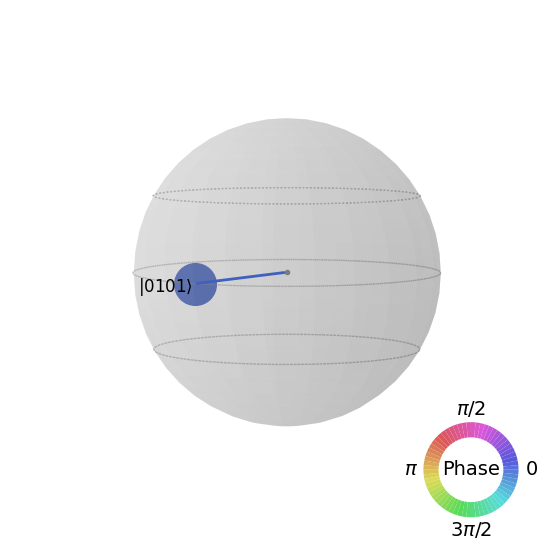

In [76]:
# visualize the graph state
from qiskit.visualization import plot_state_qsphere
from qiskit_aer import Aer


_simulator = Aer.get_backend('statevector_simulator')
_result_qc = transpile(qc, _simulator)
_fin_res = _simulator.run(_result_qc).result()
statevector = _fin_res.get_statevector()
#plot_state_qsphere(statevector)
statevector.draw('qsphere')
# plt.show()
# plot_state_qsphere(statevector)

# **Resending on Failure:**
If the stabilizer measurements do not match, the protocol would either terminate or request a resend. This logic can be handled in Python code after the circuit is executed.
# **Measurement for Summation:**
Once the graph state is verified, each participant performs a final measurement based on their key
  (X-basis or Y-basis), and the final sum
D is calculated. In Qiskit, this involves applying appropriate basis rotations before measurement.

In [77]:
# Example: Final measurements based on y_k
Y_k = [random.choice([0, 1]) for _ in range(num_participants)]

for i in range(num_participants):
    if Y_k[i] == 0:
        qc.h(qr[i])  # X-basis measurement
    else:
        qc.sdg(qr[i])  # Y-basis measurement
        qc.h(qr[i])


In [78]:
# Measure final qubits
qc.measure_all()

# Execute and retrieve the final sum
transpiled_qc = transpile(qc, simulator)
#result = execute(transpiled_qc, simulator, shots=1024).result()
result = simulator.run(transpiled_qc, shots=1024).result()
counts = result.get_counts()
print("Final result:", counts)

Final result: {'0011 1000': 3, '1100 0010': 2, '1111 1101': 5, '1011 1010': 4, '1010 0110': 2, '1100 1101': 8, '1101 0110': 1, '0101 0101': 4, '0001 1001': 2, '1010 0010': 1, '0101 0011': 2, '1010 1100': 1, '0000 0011': 1, '1100 0100': 5, '0010 0010': 3, '1100 0001': 4, '1100 1010': 4, '1100 0011': 2, '0000 0100': 3, '0001 0101': 1, '1100 0111': 1, '0111 1100': 2, '1100 1011': 5, '1111 0000': 4, '0011 0100': 3, '1000 0111': 4, '0101 1110': 3, '1000 1011': 3, '0100 1011': 1, '0101 1001': 1, '0110 0100': 2, '0010 0110': 3, '0010 0100': 3, '0000 0110': 5, '1110 0001': 6, '0010 0101': 4, '0011 0110': 7, '0111 1010': 4, '0010 1110': 2, '0001 0100': 3, '0001 1100': 2, '1011 0000': 5, '1110 1110': 2, '1000 1110': 3, '1101 1111': 3, '0010 0011': 3, '0010 1010': 8, '0111 1110': 2, '1010 1111': 4, '0010 0111': 5, '1101 1001': 3, '1101 1100': 6, '0111 1011': 3, '1111 0101': 2, '1110 0010': 8, '1111 1011': 4, '0011 1110': 3, '0111 1000': 9, '1110 0111': 6, '1010 1000': 2, '0000 1011': 2, '0011 000

In [79]:
print_final_result(counts)


Final Result (Formatted):

Binary sequence: 0011 1000, Frequency: 3
Binary sequence: 1100 0010, Frequency: 2
Binary sequence: 1111 1101, Frequency: 5
Binary sequence: 1011 1010, Frequency: 4
Binary sequence: 1010 0110, Frequency: 2
Binary sequence: 1100 1101, Frequency: 8
Binary sequence: 1101 0110, Frequency: 1
Binary sequence: 0101 0101, Frequency: 4
Binary sequence: 0001 1001, Frequency: 2
Binary sequence: 1010 0010, Frequency: 1
Binary sequence: 0101 0011, Frequency: 2
Binary sequence: 1010 1100, Frequency: 1
Binary sequence: 0000 0011, Frequency: 1
Binary sequence: 1100 0100, Frequency: 5
Binary sequence: 0010 0010, Frequency: 3
Binary sequence: 1100 0001, Frequency: 4
Binary sequence: 1100 1010, Frequency: 4
Binary sequence: 1100 0011, Frequency: 2
Binary sequence: 0000 0100, Frequency: 3
Binary sequence: 0001 0101, Frequency: 1
Binary sequence: 1100 0111, Frequency: 1
Binary sequence: 0111 1100, Frequency: 2
Binary sequence: 1100 1011, Frequency: 5
Binary sequence: 1111 0000, Fr